In [49]:
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from math import log
from sklearn.metrics import r2_score
import time
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoLarsIC
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
import math

***Part 1***

In [50]:
# Reading the data
mpg = pd.read_csv("assignment4.csv", index_col = 0)
mpg.head()
mpg.isna().sum()

mpg             0
cylinders       0
displacement    0
horsepower      0
weight          0
acceleration    0
model year      0
origin          0
dtype: int64

In [51]:
y = mpg['mpg']

In [52]:
x = mpg.drop('mpg', axis = 1)

***Train Test Split 1(20% Training Data)***

In [53]:
x_train1, x_test1, y_train1, y_test1 = train_test_split(x, y, test_size=0.2, random_state=42)

In [54]:
model_1 = Lasso()
model_1.fit(x_train1, y_train1)
y_pred1 = model_1.predict(x_test1)
r2 = r2_score(y_test1, y_pred1)
print("OOS R-square value:", r2*100)
print("RMSE:",round(math.sqrt(mean_squared_error(y_test1, y_pred1)),3))

OOS R-square value: 83.04848927901433
RMSE: 3.019


In [55]:
x_train2, x_test2, y_train2, y_test2 = train_test_split(x, y, test_size=0.8, random_state=42)

In [56]:
model_2 = Lasso()
model_2.fit(x_train2, y_train2)
y_pred2 = model_2.predict(x_test2)
r2 = r2_score(y_test2, y_pred2)
print("OOS R-square value:", r2*100)
print("RMSE:",round(math.sqrt(mean_squared_error(y_test2, y_pred2)),3))

OOS R-square value: 78.9597458111637
RMSE: 3.592


**From the RMSE values and $OOS\ R^2$ values of the models with 20% and 80% data, it is concluded that the model that uses 80% training data is performing better.**  
**Hence, the principle of parsimony is followed by choosing 3 variables to explain the model rather than 5. Thereby, this will be the base model with same split of data for further questions**

***Part 2***

In [57]:
#Defining the lasso function
lasso_lars_ic = make_pipeline(
    StandardScaler(), LassoLarsIC(criterion="aic", normalize=False)
).fit(x_train1, y_train1)

In [58]:
results = pd.DataFrame(
    {
        "alphas": lasso_lars_ic[-1].alphas_,
        "AIC criterion": lasso_lars_ic[-1].criterion_,
    }
).set_index("alphas")
alpha_aic = lasso_lars_ic[-1].alpha_

In [59]:
lasso_lars_ic.set_params(lassolarsic__criterion="bic").fit(x_train1, y_train1)
results["BIC criterion"] = lasso_lars_ic[-1].criterion_
alpha_bic = lasso_lars_ic[-1].alpha_

In [60]:
def highlight_min(x):
    x_min = x.min()
    return ["font-weight: bold" if v == x_min else "" for v in x]

results.style.apply(highlight_min)

,AIC criterion,BIC criterion
alphas,,
6.55090058802256,318.000000,318.000000
3.777041444220047,174.693868,178.455920
1.4298798353209137,82.287762,89.811865
1.2214663973644484,79.327560,90.613714
0.09293700504540175,67.908889,82.957094
0.049379306927527504,69.838785,88.649042
0.012186346354541619,71.214774,93.787082
0.0,73.142295,99.476655


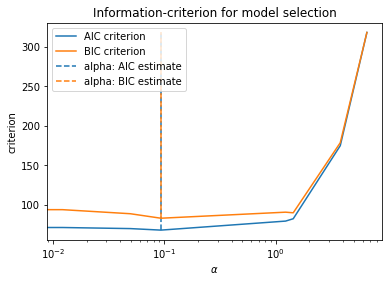

In [65]:
# Graph to display these criterion values on model selection
ax = results.plot()
ax.vlines(
    alpha_aic,
    results["AIC criterion"].min(),
    results["AIC criterion"].max(),
    label="alpha: AIC estimate",
    linestyles="--",
    color="tab:blue",
)
ax.vlines(
    alpha_bic,
    results["BIC criterion"].min(),
    results["BIC criterion"].max(),
    label="alpha: BIC estimate",
    linestyle="--",
    color="tab:orange",
)
ax.set_xlabel(r"$\alpha$")
ax.set_ylabel("criterion")
ax.set_xscale("log")
ax.legend()
_ = ax.set_title(
    f"Information-criterion for model selection"
)

In [66]:
model = Lasso(alpha=0.09294)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
r2_score(y_test, y_pred)
print("OOS R-square value:", r2*100)
print("RMSE:",round(math.sqrt(mean_squared_error(y_test1, y_pred1)),3))

OOS R-square value: 78.9597458111637
RMSE: 3.019


In [67]:
model.coef_

array([-0.        ,  0.00938627, -0.01203483, -0.00671665,  0.04312708,
        0.78702271,  1.05078084])

**With the AIC and BIC at 80% split for training data, the optimal value of $\alpha is: 0.09294$**

The LassoLarsIC class uses different values of $\alpha$, for better method than making an equidistant list of $\alpha$. Further for each of $\alpha$ value, the corresponding aic and bic values are calculated. Thus the optimal value of $\alpha$ is the $\alpha$ that minimizes both aic and bic.

***Part 3***

In [68]:
lm = LinearRegression()
folds = KFold(n_splits = 10, shuffle = True, random_state = 0)
scores = cross_val_score(lm, x_train, y_train, scoring='r2', cv=folds)
mean_scores = scores.mean()
print("The average OOS R squared value for cross validation:",mean_scores*100)

The average OOS R squared value for cross validation: 78.98758517022166


**The OOS R-squared value of a full model using simple linear regression on average is 78.98%. Thus indicating that when compared to an optimized Lasso Regression model, the lasso model is able to make better predictions despite using only 4 variables as compared to 7 variables in the full regression model.**

***Part 4***

In [69]:
ytrain1_pred = model_1.predict(x_train1)
mse1 = mean_squared_error(y_train1, ytrain1_pred)

In [70]:
model_1.coef_

array([ 0.        , -0.        , -0.00532359, -0.00665824,  0.        ,
        0.704171  ,  0.        ])

In [71]:
num_params1 = 4 
print('Number of non zero-parameters: %d' % (num_params1))

Number of non zero-parameters: 4


***Evaluation Criteria for Model_1***

In [72]:
aic1 = len(y_train1) * log(mse1) + 2 * num_params1  
print('AIC: %d' % (aic1))
aic_c1 = aic1 + (2*num_params1*(num_params1+1))/(len(y_train1) - num_params1 - 1)
print('AICC: %d' % (aic_c1))
bic1 = len(y_train1) * log(mse1) + num_params1 * log(len(y_train1))
print('BIC: %d' % (bic1))

AIC: 808
AICC: 808
BIC: 823


In [73]:
model.coef_

array([-0.        ,  0.00938627, -0.01203483, -0.00671665,  0.04312708,
        0.78702271,  1.05078084])

***Evaluation Criteria for Model***

In [74]:
num_params2 = 6
print('Number of non-zero parameters: %d' % (num_params2))

ytrain2_pred = model.predict(x_train1)
mse2 = mean_squared_error(y_train1, ytrain2_pred)
aic2 = len(y_train1) * log(mse2) + 2 * num_params2
print('AIC: %d' % (aic2))
aic_c2 = aic2+ (2*num_params2*(num_params2+1))/(len(y_train1) - num_params2 - 1)
print('AICC: %d' % (aic_c2))
bic2 = len(y_train1) * log(mse2) + num_params2 * log(len(y_train1))
print('BIC: %d' % (bic2))

Number of non-zero parameters: 6
AIC: 793
AICC: 794
BIC: 816


**As seen from above evaluation criteria for the model that the AIC, AICc and BIC values are all lower for the model with the optimal value of $\alpha$ (Ques 2). Thus it can be concluded that the out of sample performance would be better for model with optimal $\alpha$.**  
  
**In addition it can be observe that the values of AIC and AICc are nearly close which is because with the increase in sample size, the value for AICc approaches AIC.**  
  
**Also, notice that the BIC value is always higher than the AIC and AICc value which is because of the penalty parameter in AIC is 2 where as it is log(n) in BIC. Thus as long as the number of observations are more than 6, the value for BIC will always exceed the value for AIC.**

***Part 5***

Randomized Control Trials methodology is used to establish causal effects (real world effects). They are used to measure the impact of the change in a treatment of 'd' group population. An example of such method a to establish causal treatment effects (TE) is A/B Testing. A/B Testing includes dividision of a homogenous population into two random groups, control and test/treatment groups respectively. The test/treatment group is one which receives the treatment where as the control group is the one that receives the placebo or maintained at the existing state. Keeping all other factors constant, the impact of the treatment on both the groups is measured and the causal effect of the treatment are obtained.

The benefit of using RCT is that it establishes a platform to excercise causality. With observational studies only inference can be procured on the correlation instead of using experimental studies like RCT, when performed well, brings the causal nature of the treatment into picture.

Methods:

When the nature of the outcome variable is binary, then logistic regression can be used to calculate the treatment effect.

When  the nature of the outcome variable is continuous, then methods like ANOVA/ANCOVA and linear regression can be used to determine the treatment effect.